# Data Generation

This notebook helps in the creation of synthetic data.

In [2]:
import numpy as np
import pandas as pd
import Perceptron.perceptron as pn
from Perceptron.data_gen import Universe, separable_regression, data_distribution
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, zero_one_loss
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import math
from tqdm import tqdm
from argparse import ArgumentParser, RawTextHelpFormatter 
import random
from scipy.io import arff
import matplotlib.pyplot as plt


## Data Corruption Experiment
from typing import List, Tuple
import random

In [3]:
# Experiment required functions
def sample_data(
    lows:      List[float],
    highs:     List[float],
    n_samples: int,
    seed:      int=None
) -> List[List[int]]:
    """Sample uniform distribution bounded by lows and highs
    
        Using a uniform distribution, perform sampling over the 
    distribution such that the space the distribution is sampling will 
    be bounded by the given bounds from the lows and highs. Lows and 
    highs will be arrays that contain the minimum and maximum values 
    per dimension on the data to be samples. For example, if we have 4 
    values in both lows and highs, then, at the time of sampling n_samples
    samples we will have n_samples of 4 attributes each: (n_samples, 4).
    """
    
    assert len(lows) == len(highs), f"Non-matching lows and highs: {len(lows) != {len(highs)}}"
    
    rng = np.random.default_rng(seed)
    data_shape = (n_samples, len(lows)) # See assertion #1
    data = rng.uniform(lows, highs, data_shape)
    return data

# splitting the dataset into bins can be done with: np.split(data, n_buckets)
# Recommend shuffling beforehand tho.

class Concept:
    """Label given data
    Using a model as truth, label given data.
    """
    def __init__(self, model):
        self.model = model
        
    def __call__(self, X):
        return self.model.solve(X)
    
    
class NPolynomial:
    
    def __init__(self, 
                 n:    int, 
                 low:  float=0, 
                 high: float=1, 
                 seed: int=42
                ):
        self.n     = n
        self.seed  = seed
        self.low   = low
        self.high  = high
        rng        = np.random.default_rng(seed)
        self.coeff = rng.uniform(low, high, (n, 1))
        self.exps  = [exp for exp in range(n)[::-1]]
        
    def solve(self, vals):
        var = np.power(vals, self.exps)
        activation = np.sign(var @ self.coeff)                                        
        activation[activation == 0] = -1
        return activation
    


## Main Generator

In [4]:
def generate_data(
    n_data:       int,
    n_dimensions: int, 
    bounds:       Tuple[float, float],
    seed:         int,
    separable:    bool,
    bias:         bool=True,
    save_to:      str=None,
    get_concept:   bool=False
    ):
    
    if bias:
        lows      = ([bounds[0]] * n_dimensions) + [1]
        highs     = ([bounds[1]] * n_dimensions) + [1]
    else:
        lows      = [bounds[0]] * n_dimensions
        highs     = [bounds[1]] * n_dimensions
        
    assert len(lows) == len(highs), f"upper and lower bounds do not match: {lows} vs {highs}"
    
    data = sample_data(lows, highs, n_samples=n_data, seed=seed)
    
    if separable:
        rng      = np.random.default_rng(seed) # For reproducibility
        W        = np.concatenate([ rng.uniform(bounds[0], bounds[1], (n_dimensions + bias, 1)) ])
        truth    = pn.PocketPerceptron()
        truth.pi = truth.W = W
        # Concept is just a wrapper. Do truth.predict for same result
        concept  = Concept(truth)
    else:
        truth    = NPolynomial(n_dimensions + bias, bounds[0], bounds[1], seed)
        # Concept is just a wrapper. Do truth.predict for same result
        concept  = Concept(truth)
        
    labels = concept(data)
    
    if save_to is not None:
        cucumber = {
            'X': data,
            'y': labels
        }

        with open(save_to, 'wb') as jar:
            pickle.dump(cucumber, jar)
    if get_concept:
        return data, labels, concept
    else:
        return data, labels, None



## Separable

We will be using 3,000 datapoints. With those, we will make datasets with the following dimensions:

- 4
- 10
- 25
- 50
- 100

In [21]:
n_data = 3_000
dimensions = [100] #[4, 10, 25, 50, 100]
bounds = [-10, 10]
seed = 42
separable = True
get_concept = True
root_dir = None #'datasets/'


for dim in tqdm(dimensions):
    
    if separable:
        data_type = "lin"
    else:
        data_type = "non"
        
    if root_dir is not None:
        file_name = root_dir + f"synthetic_{data_type}_n_{n_data}_dims_{dim}_bounds_{bounds[0]}_{bounds[1]}.pkl"
    else:
        file_name = None
    
    X, y, concept = generate_data(
        n_data       = n_data,
        n_dimensions = dim,
        bounds       = bounds,
        seed         = seed,
        separable    = separable,
        bias         = True,
        save_to      = file_name,
        get_concept  = get_concept,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.25it/s]


In [60]:
with open('datasets/syn-lin-temp.pkl', 'rb') as jar:
    data = pickle.load(jar)
    
X, y = data['X'], data['y']

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=None #seed + run # This way data is shuffled differently every run!
)
for train_i, test_i in sss.split(X, y):
    train_data, train_labels = X[train_i], y[train_i]
    test_data, test_labels = X[test_i], y[test_i]


In [61]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score


clf = Perceptron(tol=1e-8, max_iter=3000, alpha=1, n_iter_no_change=25)
clf.fit(train_data, train_labels)
clf.score(test_data, test_labels)

#y_pred = clf.predict(X)
#accuracy_score(y, y_pred)



/home/joseaguilar/coding/github/McNair-Diochnos-Research/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9816666666666667

In [24]:
y_pred = concept(X)
accuracy_score(y, y_pred)


1.0

In [25]:
concept.model.W

array([[ 5.47912097],
       [-1.2224312 ],
       [ 7.1719584 ],
       [ 3.94736058],
       [-8.11645304],
       [ 9.51244703],
       [ 5.22279404],
       [ 5.72128611],
       [-7.43772735],
       [-0.99228124],
       [-2.58403952]])

In [26]:
clf.coef_

array([[ 261.6915665 ,  -42.9388564 ,  342.88725188,  184.789882  ,
        -379.26908142,  446.31594191,  236.48178486,  270.10011256,
        -354.34843852,  -46.23521036,  -62.        ]])

In [63]:
percep = pn.PocketPerceptron(input=101, eta=1, max_iter=2000, patience=25)
percep.train(train_data, train_labels)

In [64]:
y_pred = percep.solve(test_data)
accuracy_score(test_labels, y_pred)

0.9766666666666667

In [59]:
percep.W

array([[ 268.38787325],
       [ -89.55147106],
       [ 367.19905572],
       [ 202.70609947],
       [-388.86529533],
       [ 453.42233259],
       [ 214.84498283],
       [ 264.14486329],
       [-349.15951202],
       [ -87.88993646],
       [-138.66117902],
       [ 402.92874756],
       [ 136.93241654],
       [ 323.69319507],
       [ -92.55983519],
       [-273.70061453],
       [  78.39748706],
       [-427.46524031],
       [ 346.90887002],
       [ 128.04719072],
       [ 244.22172883],
       [-139.15951242],
       [ 463.91404515],
       [ 366.19169607],
       [ 241.52252265],
       [-288.80474616],
       [ -59.85571646],
       [-429.90686791],
       [-320.63292965],
       [ 171.07439288],
       [ 232.02914463],
       [ 447.29944563],
       [-161.92861482],
       [-125.58367679],
       [   5.96834566],
       [-278.13752348],
       [-362.03640434],
       [ -49.368269  ],
       [-246.85205404],
       [ 121.31244361],
       [ -74.65911116],
       [ 358.551

<AxesSubplot:xlabel='0', ylabel='1'>

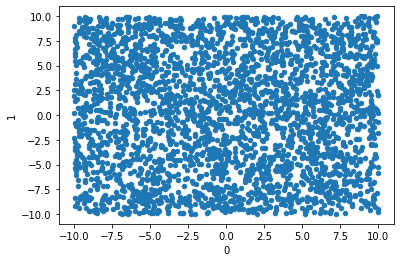

In [69]:
pd.DataFrame([*X]).plot.scatter(0, 1)

## Skin Dataset

In [23]:
skin = pd.read_csv('./datasets/skinNoSkin.csv')

In [24]:
skin

,V1,V2,V3,Class
0,74.0,85.0,123.0,1
1,73.0,84.0,122.0,1
2,72.0,83.0,121.0,1
3,70.0,81.0,119.0,1
4,70.0,81.0,119.0,1
...,...,...,...,...
245052,163.0,162.0,112.0,2
245053,163.0,162.0,112.0,2
245054,163.0,162.0,112.0,2
245055,163.0,162.0,112.0,2


In [25]:
X, y = skin.drop('Class', axis=1), skin['Class']


y.replace(1, -1, inplace=True)
y.replace(2, 1, inplace=True)


sss = StratifiedShuffleSplit(
    n_splits=1,
    train_size=3_000,
    random_state=None #seed + run # This way data is shuffled differently every run!
)
for train_i, test_i in sss.split(X, y):
    train_data, train_labels = X.iloc[train_i], y.iloc[train_i]
    test_data, test_labels = X.iloc[test_i], y.iloc[test_i]

In [27]:
train_labels.value_counts()

 1    2377
-1     623
Name: Class, dtype: int64

In [29]:
train_data.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)

cucumber = {
    'X': train_data,
    'y': train_labels,
}
save_to = f'datasets/3000_skin.pkl'
with open(save_to, 'wb') as jar:
    pickle.dump(cucumber, jar)

In [16]:
with open('datasets/3000_skin.pkl', 'rb') as pkl:
    data = pickle.load(pkl)

In [18]:
data['X']

,V1,V2,V3
0,151.0,152.0,102.0
1,201.0,200.0,162.0
2,182.0,178.0,137.0
3,42.0,40.0,9.0
4,176.0,174.0,126.0
...,...,...,...
2995,174.0,172.0,124.0
2996,4.0,1.0,181.0
2997,163.0,163.0,115.0
2998,56.0,116.0,182.0
